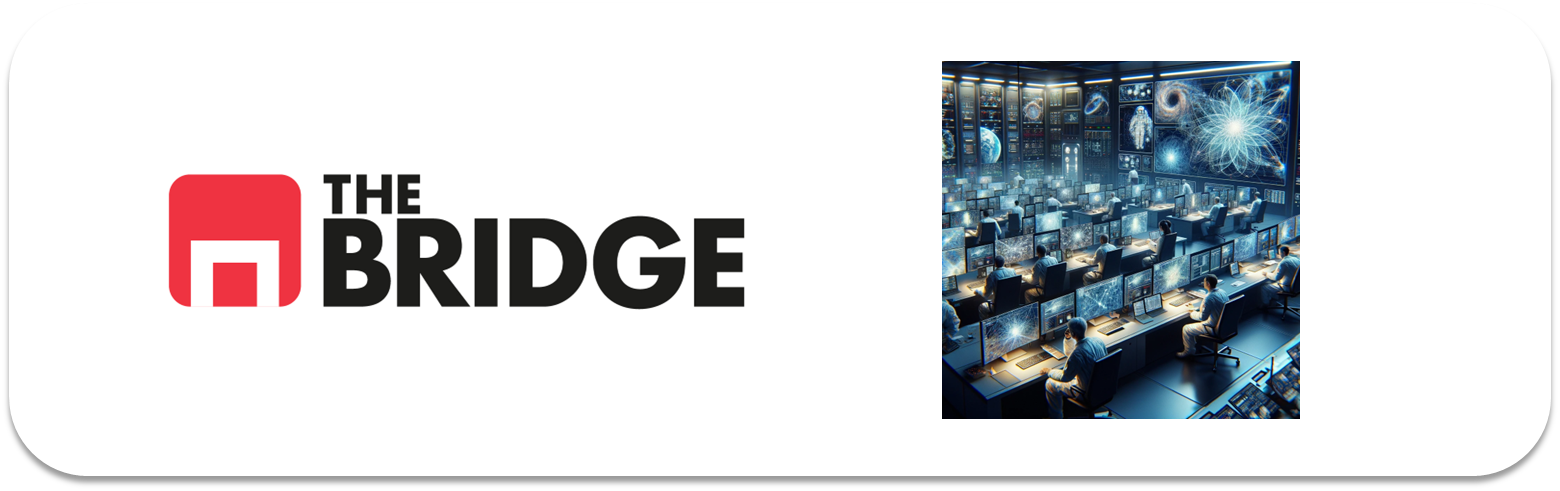

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior. Los datos los encontrarás en https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test como `seg_train.zip` y `seg_test.zip` (o bien en el botón de download).  


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [8]:
# Definir rutas y parámetros
train_dir = "seg_train"  # Directorio de entrenamiento
test_dir = "seg_test"    # Directorio de test
IMG_SIZE = 224           # Tamaño de imagen esperado por MobileNetV2
batch_size = 32

In [9]:
# =============================================================================
# Funciones de visualización
# =============================================================================
def plot_history(history, title):
    # Gráfico de accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='accuracy entrenamiento')
    plt.plot(history.history['val_accuracy'], label='accuracy validación')
    plt.title(title + " - Accuracy")
    plt.legend()
    plt.show()
    
    # Gráfico de pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='pérdida entrenamiento')
    plt.plot(history.history['val_loss'], label='pérdida validación')
    plt.title(title + " - Pérdida")
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Matriz de confusión'):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    plt.show()

In [10]:
# =============================================================================
# Preparación de datos sin aumento
# =============================================================================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # Separa el 20% para validación
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    subset="training",
    class_mode="categorical"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    subset="validation",
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Número de clases:", num_classes)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Número de clases: 6


In [11]:
# =============================================================================
# Definición de modelos
# =============================================================================
def build_transfer_model():
    """Construye el modelo de transfer learning usando MobileNetV2 con la cabeza de hasta 2 capas densas ocultas."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Congelar la base
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # Primera capa oculta
    x = Dense(64, activation='relu')(x)   # Segunda capa oculta
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_fine_tuning_model():
    """Construye el modelo para fine tuning, descongelando las últimas capas de MobileNetV2."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # Descongelar a partir de una capa (por ejemplo, desde la capa 100)
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_custom_cnn():
    """Modelo CNN ad-hoc para comparación."""
    model = Sequential()
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


=== Transfer Learning ===
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 281s 788ms/step - accuracy: 0.8439 - loss: 0.4339 - val_accuracy: 0.9112 - val_loss: 0.2629
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 276s 785ms/step - accuracy: 0.9151 - loss: 0.2154 - val_accuracy: 0.8987 - val_loss: 0.2897
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 269s 767ms/step - accuracy: 0.9309 - loss: 0.1817 - val_accuracy: 0.9126 - val_loss: 0.2432
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 292s 830ms/step - accuracy: 0.9489 - loss: 0.1388 - val_accuracy: 0.8962 - val_loss: 0.3100
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 295s 838ms/step - accuracy: 0.9507 - loss: 0.1280 - val_accuracy: 0.9051 - val_loss: 0.2894
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 295s 841ms/step - accuracy: 0.9638 - loss: 0.1008 - val_accuracy: 0.8937 - val_loss: 0.3122
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 291s 828ms/step - accuracy: 0.9660 - loss: 0.0874 - val_accuracy: 0.9087 - val_loss: 0.2956
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 322s 917m

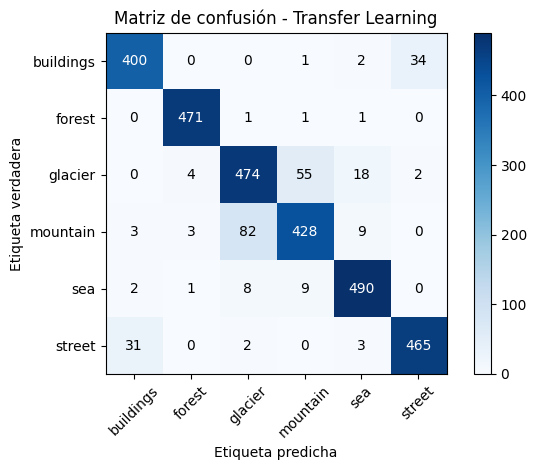

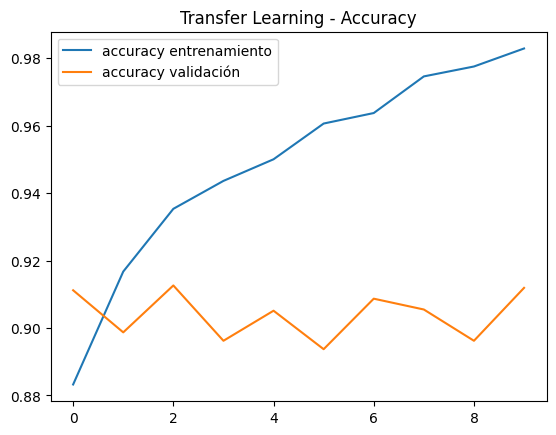

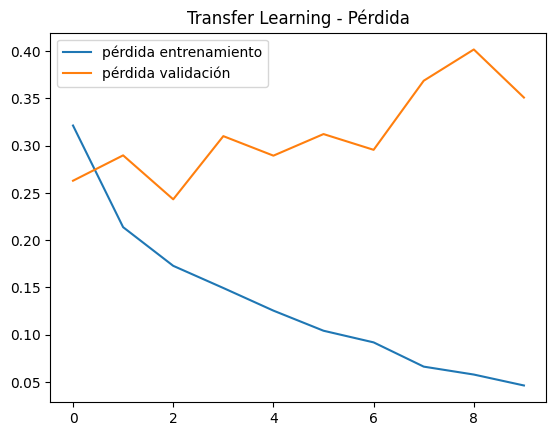

In [12]:
# =============================================================================
# Entrenamiento y evaluación de Transfer Learning
# =============================================================================
print("\n=== Transfer Learning ===")
transfer_model = build_transfer_model()
history_transfer = transfer_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

loss_transfer, acc_transfer = transfer_model.evaluate(test_generator)
print("Exactitud en test (Transfer Learning):", acc_transfer)

# Predicciones y métricas
y_pred = transfer_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("\nReporte de clasificación (Transfer Learning):")
print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm, classes=list(train_generator.class_indices.keys()), title='Matriz de confusión - Transfer Learning')
plot_history(history_transfer, "Transfer Learning")


=== Fine Tuning ===
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.4261 - loss: 1.4650 - val_accuracy: 0.7464 - val_loss: 0.8022
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.8660 - loss: 0.4930 - val_accuracy: 0.8384 - val_loss: 0.4911
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.9001 - loss: 0.3079 - val_accuracy: 0.8841 - val_loss: 0.3444
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.9173 - loss: 0.2442 - val_accuracy: 0.8984 - val_loss: 0.3066
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.9341 - loss: 0.2055 - val_accuracy: 0.9151 - val_loss: 0.2651
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.9418 - loss: 0.1748 - val_accuracy: 0.9173 - val_loss: 0.2607
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - accuracy: 0.9436 - loss: 0.1595 - val_accuracy: 0.9226 - val_loss: 0.2356
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.9555 - lo

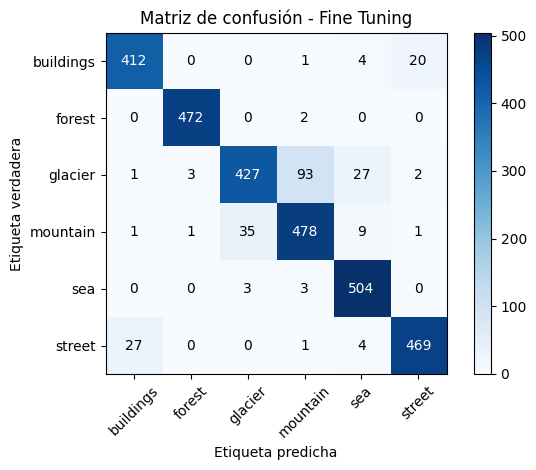

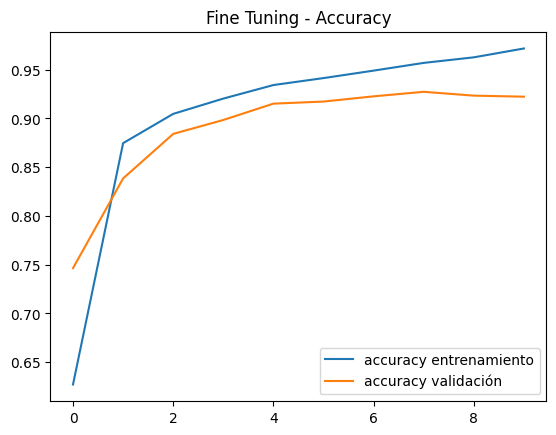

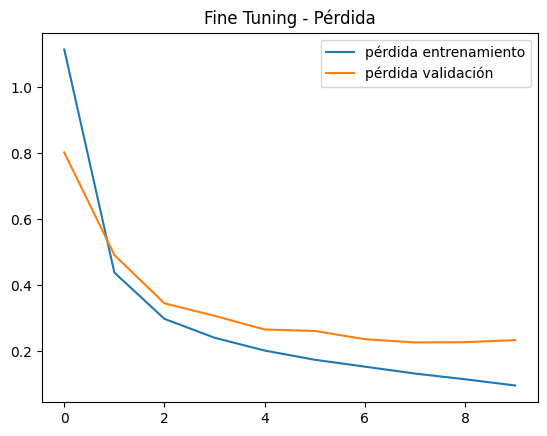

In [13]:
# =============================================================================
# Entrenamiento y evaluación de Fine Tuning
# =============================================================================
print("\n=== Fine Tuning ===")
fine_tune_model = build_fine_tuning_model()
history_fine = fine_tune_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

loss_fine, acc_fine = fine_tune_model.evaluate(test_generator)
print("Exactitud en test (Fine Tuning):", acc_fine)

y_pred_ft = fine_tune_model.predict(test_generator)
y_pred_ft_classes = np.argmax(y_pred_ft, axis=1)

print("\nReporte de clasificación (Fine Tuning):")
print(classification_report(y_true, y_pred_ft_classes))

cm_ft = confusion_matrix(y_true, y_pred_ft_classes)
plot_confusion_matrix(cm_ft, classes=list(train_generator.class_indices.keys()), title='Matriz de confusión - Fine Tuning')
plot_history(history_fine, "Fine Tuning")


=== CNN Ad-hoc (Modelo personalizado) ===
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 318s 902ms/step - accuracy: 0.5804 - loss: 1.1105 - val_accuracy: 0.7500 - val_loss: 0.6890
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 316s 899ms/step - accuracy: 0.8063 - loss: 0.5457 - val_accuracy: 0.8053 - val_loss: 0.5466
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 318s 904ms/step - accuracy: 0.8757 - loss: 0.3472 - val_accuracy: 0.7967 - val_loss: 0.6031
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 317s 903ms/step - accuracy: 0.9393 - loss: 0.1832 - val_accuracy: 0.8010 - val_loss: 0.6620
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 317s 902ms/step - accuracy: 0.9736 - loss: 0.0896 - val_accuracy: 0.8042 - val_loss: 0.7879
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 317s 904ms/step - accuracy: 0.9835 - loss: 0.0551 - val_accuracy: 0.8003 - val_loss: 0.8761
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 318s 904ms/step - accuracy: 0.9834 - loss: 0.0557 - val_accuracy: 0.7817 - val_loss: 1.0865
Epoch 8/10
351/351 ━━━━━━━━━━━━━━

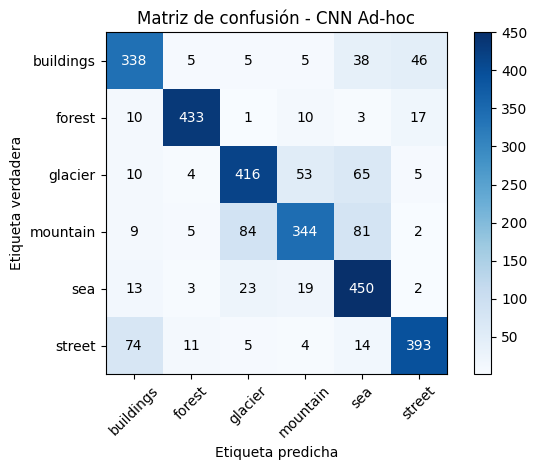

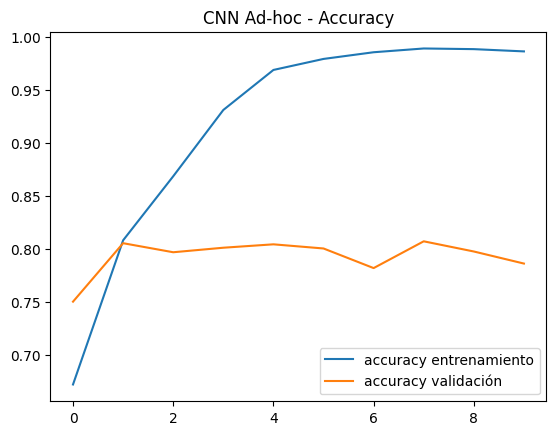

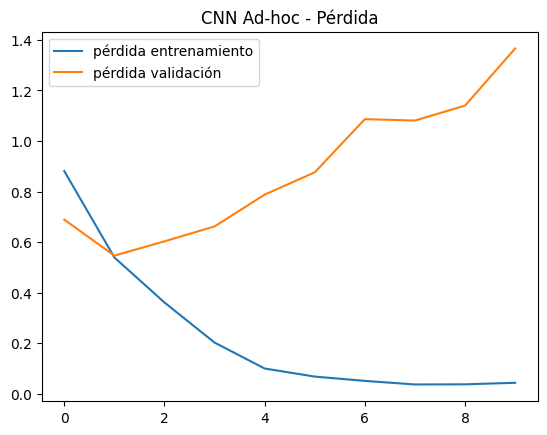

In [14]:
# =============================================================================
# Entrenamiento y evaluación de la CNN ad-hoc (modelo personalizado)
# =============================================================================
print("\n=== CNN Ad-hoc (Modelo personalizado) ===")
custom_model = build_custom_cnn()
history_custom = custom_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

loss_custom, acc_custom = custom_model.evaluate(test_generator)
print("Exactitud en test (CNN Ad-hoc):", acc_custom)

y_pred_custom = custom_model.predict(test_generator)
y_pred_custom_classes = np.argmax(y_pred_custom, axis=1)

print("\nReporte de clasificación (CNN Ad-hoc):")
print(classification_report(y_true, y_pred_custom_classes))

cm_custom = confusion_matrix(y_true, y_pred_custom_classes)
plot_confusion_matrix(cm_custom, classes=list(train_generator.class_indices.keys()), title='Matriz de confusión - CNN Ad-hoc')
plot_history(history_custom, "CNN Ad-hoc")


=== Transfer Learning con Aumento de Imágenes ===
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Epoch 1/10


c:\Users\juanmoreno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 357s 1000ms/step - accuracy: 0.7768 - loss: 0.5855 - val_accuracy: 0.8784 - val_loss: 0.3304
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 351s 994ms/step - accuracy: 0.8832 - loss: 0.3221 - val_accuracy: 0.8877 - val_loss: 0.3054
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.8897 - loss: 0.3034 - val_accuracy: 0.8827 - val_loss: 0.3192
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.8995 - loss: 0.2737 - val_accuracy: 0.8852 - val_loss: 0.3120
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.9002 - loss: 0.2670 - val_accuracy: 0.9016 - val_loss: 0.2685
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9036 - loss: 0.2624 - val_accuracy: 0.8887 - val_loss: 0.3028
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9066 - loss: 0.2515 - val_accuracy: 0.8937 - val_loss: 0.2805
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.9117 - loss: 0.2325 - val_accuracy

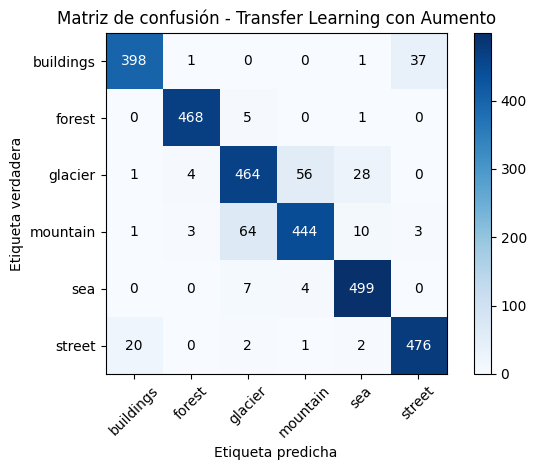

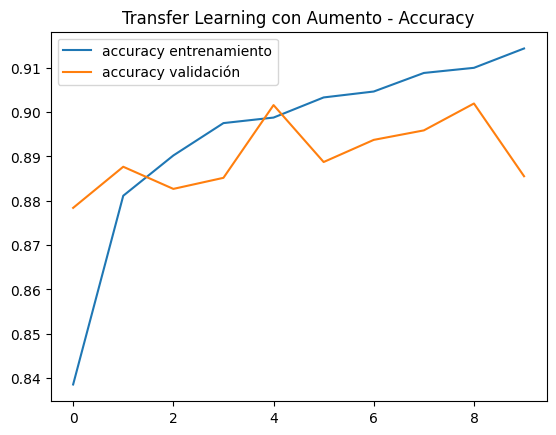

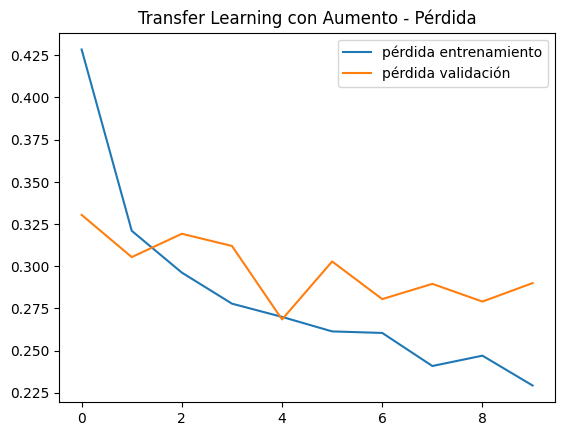

In [15]:
# =============================================================================
# EXTRA: Transfer Learning con Aumento de Imágenes
# =============================================================================
print("\n=== Transfer Learning con Aumento de Imágenes ===")
train_datagen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    subset="training",
    class_mode="categorical"
)

val_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    subset="validation",
    class_mode="categorical"
)

transfer_model_aug = build_transfer_model()
history_transfer_aug = transfer_model_aug.fit(
    train_generator_aug,
    epochs=10,
    validation_data=val_generator_aug
)

loss_transfer_aug, acc_transfer_aug = transfer_model_aug.evaluate(test_generator)
print("Exactitud en test (Transfer Learning con Aumento):", acc_transfer_aug)

y_pred_aug = transfer_model_aug.predict(test_generator)
y_pred_aug_classes = np.argmax(y_pred_aug, axis=1)

print("\nReporte de clasificación (Transfer Learning con Aumento):")
print(classification_report(y_true, y_pred_aug_classes))

cm_aug = confusion_matrix(y_true, y_pred_aug_classes)
plot_confusion_matrix(cm_aug, classes=list(train_generator.class_indices.keys()), title='Matriz de confusión - Transfer Learning con Aumento')
plot_history(history_transfer_aug, "Transfer Learning con Aumento")